# Chapter 11: Red-Teaming an XGBoost Credit Model

## Data Poisoning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tMxexHbgNoUaeTS179bXUA7BbvkbcSOe?usp=sharing) 

# Setting the environment

Download the [zipped **Data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/chapter-11/Data.zip) onto your local system and save it as `Data.zip`. 

In [2]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [3]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [4]:
# Installing the libraries
%pip install h2o 
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.4 MB 34 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.2-py2.py3-none-any.whl size=177521195 sha256=cb11a55906954506ee299255a8f8b169b9726222a6a9e0ede18a780e0e072fd6
  Stored in directory: /root/.cache/pip/wheels/e4/ef/ab/a9b2e452e18b3dfea0b6114bc57c3b9e8b0e464eb2d03230e1
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 39 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


Global hyperpameters

In [5]:
SEED = 12345 # global random seed for better reproducibility

Python imports and inits

In [6]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np   
import pandas as pd 

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999 

h2o.init(max_mem_size='4G')     
h2o.remove_all()               
h2o.no_progress()              

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgtj1t54h
  JVM stdout: /tmp/tmpgtj1t54h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgtj1t54h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_e8yt7g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [9]:
data = pd.read_csv('../Data/credit_line_increase.csv')
data_original = data.copy()
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
data.describe()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Data Poisoing
## Select some rows to poison

In [11]:
# randomly select a small number of rows that can be changed easily
np.random.seed(SEED) # same results for each run of the cell
ids = np.random.choice(data[(data['PAY_0'] == 2) & (data['PAY_2'] == 0) & (data['DELINQ_NEXT'] == 1)].index, 8)
print(ids)

[23856 23979 14979  6957 20480 20803 18618 17793]


### Create and view rows of poisoned training data

In [12]:
# simple function for poisoning the selected rows
def poison(ids_):
    
    for i in ids_:
        
        data.loc[i, 'PAY_0'] = 1.5
        data.loc[i, 'PAY_AMT4'] = 2323 # leave a watermark, optional 
        data.loc[i, 'DELINQ_NEXT'] = 0 # update target 
        
poison(ids)

poisoned_rows = data.iloc[ids, :] # reinsert poisoned data into training data
non_poisoned_data = data.drop(data.index[[ids]])
poisoned_data = pd.concat([non_poisoned_data, poisoned_rows])
poisoned_data.sort_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


### Splitting dataset into train, validation and test set


In [13]:
np.random.seed(SEED)
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(poisoned_data)) < split_ratio
train_poisoned = poisoned_data[split] # contains a small amount of poisoned data 
valid_poisoned = poisoned_data[~split] # contains a small amount of poisoned data

train = data_original[split]
valid = data_original[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 20946, columns = 26
Validation data rows = 9054, columns = 26


## Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [14]:
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in train.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DELINQ_NEXT
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [15]:
# Converting Pandas dataframe into H2O Frame

training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)

training_frame_poisoned = h2o.H2OFrame(train_poisoned)
validation_frame_poisoned = h2o.H2OFrame(valid_poisoned)

In [16]:
# Setting target column to factor so we can build classification model

training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
training_frame_poisoned[target] = training_frame_poisoned[target].asfactor()
validation_frame_poisoned[target] = validation_frame_poisoned[target].asfactor()

## Training an Overfit H2O XGBoost model on Poisoned Data

### Setting XGBooost Parameters



In [17]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.1
    , "sample_rate" : 0.9
    , "col_sample_rate_per_tree" : 1
    , "min_rows" : 5
    , "seed": SEED
    , "score_tree_interval": 10
}

In [18]:
xgb_overfit = H2OXGBoostEstimator(**param)
xgb_overfit_poisoned = H2OXGBoostEstimator(**param)

In [19]:
#Training  XGBoost model on poisoned data
xgb_overfit = xgb_overfit.train(x=features, y=target, 
                                training_frame=training_frame, 
                                validation_frame=validation_frame)
xgb_overfit_poisoned = xgb_overfit_poisoned.train(x=features, y=target, 
                                                  training_frame=training_frame_poisoned, 
                                                  validation_frame=validation_frame_poisoned)

## Compare Poisoned and Unpoisoned Models

In [20]:
overfit_xgb_preds = xgb_overfit.predict(h2o.H2OFrame(poisoned_rows)).as_data_frame()
overfit_xgb_preds = overfit_xgb_preds.join(xgb_overfit_poisoned.predict(h2o.H2OFrame(poisoned_rows)).as_data_frame(), 
                                           rsuffix='_poisoned')
overfit_xgb_preds

,predict,p0,p1,predict_poisoned,p0_poisoned,p1_poisoned
0,1,0.212788,0.787212,0,0.839975,0.160025
1,1,0.165027,0.834973,1,0.497681,0.502319
2,1,0.217597,0.782403,0,0.883557,0.116443
3,1,0.240691,0.759309,0,0.870262,0.129738
4,1,0.354199,0.645801,0,0.805784,0.194216
5,1,0.256816,0.743184,0,0.870403,0.129597
6,1,0.271266,0.728734,0,0.855052,0.144948
7,1,0.139171,0.860829,0,0.882010,0.117990


In [25]:
overfit_unpoisoned_preds = xgb_overfit.predict(h2o.H2OFrame(poisoned_data)).as_data_frame()
overfit_poisoned_preds = xgb_overfit_poisoned.predict(h2o.H2OFrame(poisoned_data)).as_data_frame()

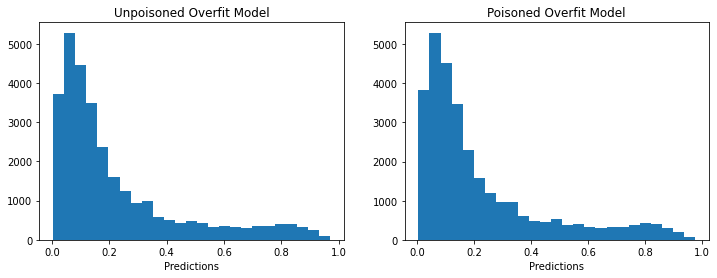

In [28]:
bins=25

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(overfit_unpoisoned_preds['p1'], bins=bins)
axs[0].set_title('Unpoisoned Overfit Model')
axs[0].set_xlabel('Predictions')


axs[1].hist(overfit_poisoned_preds['p1'], bins=bins)
_ = axs[1].set_title('Poisoned Overfit Model')
axs[1].set_xlabel('Predictions')


In [31]:
preds = overfit_unpoisoned_preds.join(overfit_poisoned_preds, rsuffix='_poisoned')
preds['diff'] = np.abs(preds['p1'] - preds['p1_poisoned'])
print(f"Number of rows that change scores by greater than 0.05: {(preds['diff'] > 0.05).sum()}")
print(f"Number of rows that change scores by greater than 0.1: {(preds['diff'] > 0.1).sum()}")
print(f"Number of rows that change scores by greater than 0.15: {(preds['diff'] > 0.15).sum()} \n")

print(f"Average score of poisoned model: {preds['p1_poisoned'].mean()}")
print(f"Average score of unpoisoned model: {preds['p1'].mean()}.")

Number of rows that change scores by greater than 0.05: 5214
Number of rows that change scores by greater than 0.1: 1095
Number of rows that change scores by greater than 0.15: 227 

Average score of poisoned model: 0.22219575158325025
Average score of unpoisoned model: 0.2224025306274571.


In [32]:
len(preds)

30000

---

# Train a Monotonic and L2 Regularised H2O XGBoost model on Poisoned Data


In [33]:
# params obtained out of grid Search
params_best = {'reg_lambda': 0.25,
               'min_child_weight': 1,
               'eta': 0.08,
               'subsample': 0.8,
               'colsample_bytree': 0.8,
               'seed': SEED,
               'max_depth': 3}

mono_constraints = {'BILL_AMT1': -1,
 'BILL_AMT2': -1,
 'BILL_AMT3': -1,
 'BILL_AMT4': -1,
 'BILL_AMT5': -1,
 'BILL_AMT6': -1,
 'LIMIT_BAL': -1,
 'PAY_0': 1,
 'PAY_2': 1,
 'PAY_3': 1,
 'PAY_4': 1,
 'PAY_5': 1,
 'PAY_6': 1,
 'PAY_AMT1': -1,
 'PAY_AMT2': -1,
 'PAY_AMT3': -1,
 'PAY_AMT4': -1,
 'PAY_AMT5': -1,
 'PAY_AMT6': -1}                        

In [34]:
# Applying monotonic constraints
xgb_constrained = H2OXGBoostEstimator(**params_best, monotone_constraints = mono_constraints)
xgb_constrained_poisoned = H2OXGBoostEstimator(**params_best, monotone_constraints = mono_constraints)

#Training  XGBoost model on poisoned data
xgb_constrained = xgb_constrained.train(x=features, y=target, 
                                        training_frame=training_frame, 
                                        validation_frame=validation_frame)
xgb_constrained_poisoned = xgb_constrained_poisoned.train(x=features, y=target, 
                                                          training_frame=training_frame_poisoned, 
                                                          validation_frame=validation_frame_poisoned)

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter colsample_bytree instead of col_sample_rate_per_tree."
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter subsample instead of sample_rate."
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter eta instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


In [35]:
constrained_xgb_preds = xgb_constrained.predict(h2o.H2OFrame(poisoned_rows)).as_data_frame()
constrained_xgb_preds = constrained_xgb_preds.join(xgb_constrained_poisoned.predict(h2o.H2OFrame(poisoned_rows)).as_data_frame(), 
                                                   rsuffix='_poisoned')
constrained_xgb_preds

,predict,p0,p1,predict_poisoned,p0_poisoned,p1_poisoned
0,1,0.422982,0.577018,0,0.771463,0.228537
1,1,0.338005,0.661995,1,0.636223,0.363777
2,1,0.411382,0.588618,0,0.730004,0.269996
3,1,0.416101,0.583899,0,0.746111,0.253889
4,1,0.370619,0.629381,1,0.673809,0.326191
5,1,0.441490,0.558510,0,0.781569,0.218431
6,1,0.380137,0.619863,1,0.687929,0.312071
7,1,0.416505,0.583495,0,0.754457,0.245543


In [36]:
unpoisoned_preds = xgb_constrained.predict(h2o.H2OFrame(poisoned_data)).as_data_frame()
poisoned_preds = xgb_constrained_poisoned.predict(h2o.H2OFrame(poisoned_data)).as_data_frame()

Text(0.5, 0, 'Predictions')

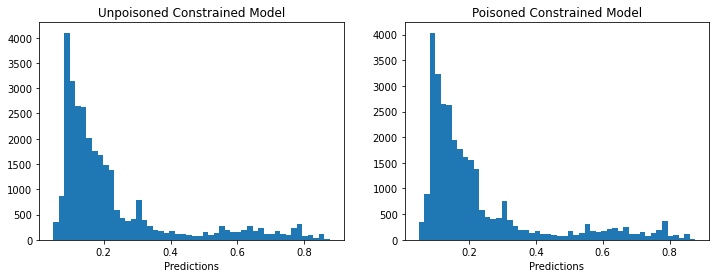

In [38]:
bins=50

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(unpoisoned_preds['p1'], bins=bins)
axs[0].set_title('Unpoisoned Constrained Model')
axs[0].set_xlabel('Predictions')


axs[1].hist(poisoned_preds['p1'], bins=bins)
_ = axs[1].set_title('Poisoned Constrained Model')
axs[1].set_xlabel('Predictions')



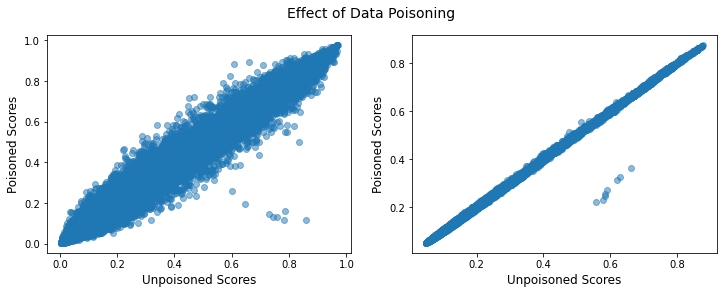

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(overfit_unpoisoned_preds['p1'], overfit_poisoned_preds['p1'], alpha=0.5)
# axs[0].set_title('Overfit Model', size=14)
axs[0].set_xlabel('Unpoisoned Scores', size=12)
axs[0].set_ylabel('Poisoned Scores', size=12)

axs[1].scatter(unpoisoned_preds['p1'], poisoned_preds['p1'], alpha=0.5)
# axs[1].set_title('Constrained Model', size=14)
axs[1].set_xlabel('Unpoisoned Scores', size=12)
axs[1].set_ylabel('Poisoned Scores', size=12)

fig.suptitle('Effect of Data Poisoning', size=14)

In [40]:
preds = unpoisoned_preds.join(poisoned_preds, rsuffix='_poisoned')
preds['diff'] = np.abs(preds['p1'] - preds['p1_poisoned'])
print(f"Number of rows that change scores by greater than 0.05: {(preds['diff'] > 0.05).sum()}")
print(f"Number of rows that change scores by greater than 0.1: {(preds['diff'] > 0.1).sum()}")
print(f"Number of rows that change scores by greater than 0.15: {(preds['diff'] > 0.15).sum()} \n")

print(f"Average score of poisoned model: {preds['p1_poisoned'].mean()}")
print(f"Average score of unpoisoned model: {preds['p1'].mean()}.")

Number of rows that change scores by greater than 0.05: 8
Number of rows that change scores by greater than 0.1: 8
Number of rows that change scores by greater than 0.15: 8 

Average score of poisoned model: 0.2268603705742707
Average score of unpoisoned model: 0.22705538112608095.


In [41]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_887e closed.


---